# 1. Import packages and data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')

df_gold  = pd.read_excel('GoldPrice_Yahoo.xlsx')
df_sp500 = pd.read_excel('S&P500_Yahoo.xlsx')
df_grisk = pd.read_excel('data_gpr_export.xls')
df_usd   = pd.read_excel('USDIndex_Yahoo.xlsx')
df_10y   = pd.read_excel('10YearTreasuryYield_Yahoo.xlsx')
df_oil   = pd.read_excel('OilPrice_Yahoo.xlsx')
df_vix   = pd.read_excel('VIX_Yahoo.xlsx')

print(df_gold.shape)
print(df_sp500.shape)
print(df_grisk.shape)
print(df_usd.shape)
print(df_10y.shape)
print(df_oil.shape)
print(df_vix.shape)

(5606, 7)
(5704, 7)
(1558, 113)
(6967, 7)
(6967, 7)
(5616, 7)
(5709, 7)


# 2. Data manipulation and exploration

In [2]:
df_grisk.dropna(subset=['GPR'], inplace=True)
df_grisk['monthyear'] = df_grisk.apply(lambda x: str(x['month'])[0:7], axis=1)

df_grisk.head()

,month,GPR,GPRT,GPRA,GPRH,GPRHT,GPRHA,SHARE_GPR,N10,SHARE_GPRH,...,GPRHC_TUN,GPRHC_TUR,GPRHC_TWN,GPRHC_UKR,GPRHC_USA,GPRHC_VEN,GPRHC_ZAF,var_name,var_label,monthyear
1020,1985-01-01,102.173378,107.574173,89.647491,87.153206,101.083145,75.144287,3.064572,11584.0,3.143987,...,0.000000,0.028932,0.038577,0.009644,2.941460,0.000000,0.221815,NaN,NaN,1985-01
1021,1985-02-01,117.102020,126.442726,96.601669,99.552269,127.213127,75.103569,3.512339,10819.0,3.591274,...,0.041161,0.030871,0.000000,0.010290,3.344310,0.072031,0.113192,NaN,NaN,1985-02
1022,1985-03-01,124.778152,127.070854,116.987274,103.822472,131.811447,78.716949,3.742576,12291.0,3.745318,...,0.017835,0.080257,0.000000,0.044587,3.433208,0.035670,0.133761,NaN,NaN,1985-03
1023,1985-04-01,87.929001,94.640198,73.757797,74.304153,91.295639,56.713566,2.637328,12816.0,2.680467,...,0.017693,0.079618,0.017693,0.017693,2.397382,0.106157,0.088464,NaN,NaN,1985-04
1024,1985-05-01,103.262848,111.159782,92.276726,84.364098,101.910835,73.034920,3.097249,13851.0,3.043372,...,0.024412,0.032549,0.008137,0.000000,2.750427,0.089511,0.195297,NaN,NaN,1985-05


In [12]:
def month(row):
    if row['month_str']=='Jan':
        val = '01'
    elif row['month_str']=='Feb':
        val = '02'
    elif row['month_str']=='Mar':
        val = '03'
    elif row['month_str']=='Apr':
        val = '04'
    elif row['month_str']=='May':
        val = '05'
    elif row['month_str']=='Jun':
        val = '06'
    elif row['month_str']=='Jul':
        val = '07'
    elif row['month_str']=='Aug':
        val = '08'
    elif row['month_str']=='Sep':
        val = '09'
    elif row['month_str']=='Oct':
        val = '10'
    elif row['month_str']=='Nov':
        val = '11'
    elif row['month_str']=='Dec':
        val = '12'
    else:
        val = 'error'
    return val

def get_monthly_prices(df, column_name):
    df = df[df['Open']!='-']
    df['month_str'] = df.apply(lambda x: x['Date'][0:3], axis=1)
    df['month_num'] = df.apply(month, axis=1)
    df['monthyear'] = df.apply(lambda x: x['Date'][-4:] + '-' + x['month_num'], axis=1)
    df_monthly = df.groupby('monthyear', as_index=False)['Open'].last()
    df_monthly.rename(columns={'Open': column_name}, inplace=True)
    
    return df_monthly

df_gold_monthly  = get_monthly_prices(df_gold , 'gold_price')
df_sp500_monthly = get_monthly_prices(df_sp500, 'sp500')
df_usd_monthly   = get_monthly_prices(df_usd  , 'usd')
df_10y_monthly   = get_monthly_prices(df_10y  , 'treasury_10y')
df_oil_monthly   = get_monthly_prices(df_oil  , 'oil_price')
df_vix_monthly   = get_monthly_prices(df_vix  , 'vix')

In [13]:
df = df_gold_monthly.merge(df_sp500_monthly, on='monthyear', how='left') \
                    .merge(df_usd_monthly  , on='monthyear', how='left') \
                    .merge(df_10y_monthly  , on='monthyear', how='left') \
                    .merge(df_oil_monthly  , on='monthyear', how='left') \
                    .merge(df_vix_monthly  , on='monthyear', how='left') \
                    .merge(df_grisk[['monthyear', 'GPR']], on='monthyear', how='left')
df.dropna(inplace=True)
df['monthyear'] = pd.to_datetime(df['monthyear'])
df.set_index('monthyear', inplace=True)

df

,gold_price,sp500,usd,treasury_10y,oil_price,vix,GPR
monthyear,,,,,,,
2000-08-01,273.9,1430.83,109.50,6.020,31.90,20.66,46.492256
2000-09-01,277.0,1517.68,112.36,5.716,33.05,16.81,52.689999
2000-10-01,272.8,1436.52,113.14,5.791,31.45,20.98,76.456528
2000-11-01,263.9,1429.40,116.60,5.740,33.15,24.07,45.060562
2000-12-01,269.7,1314.95,115.21,5.493,33.90,28.31,45.395100
...,...,...,...,...,...,...,...
2022-04-01,1935.0,4540.32,98.34,2.404,101.23,20.62,194.719543
2022-05-01,1896.7,4130.61,103.21,2.922,104.00,33.35,144.813034
2022-06-01,1831.0,4149.78,101.76,2.871,115.40,26.05,134.920151


In [14]:
df_train = df.head(185)
df_test  = df.tail(80)

# Train: 2000 to 2015
print('Train Min Date:', df_train.index.min())
print('Train Max Date:', df_train.index.max())

# Test: 2016 to 2022
print('Test Min Date: ', df_test.index.min())
print('Test Max Date: ', df_test.index.max())

Train Min Date: 2000-08-01 00:00:00
Train Max Date: 2015-12-01 00:00:00
Test Min Date:  2016-01-01 00:00:00
Test Max Date:  2022-08-01 00:00:00


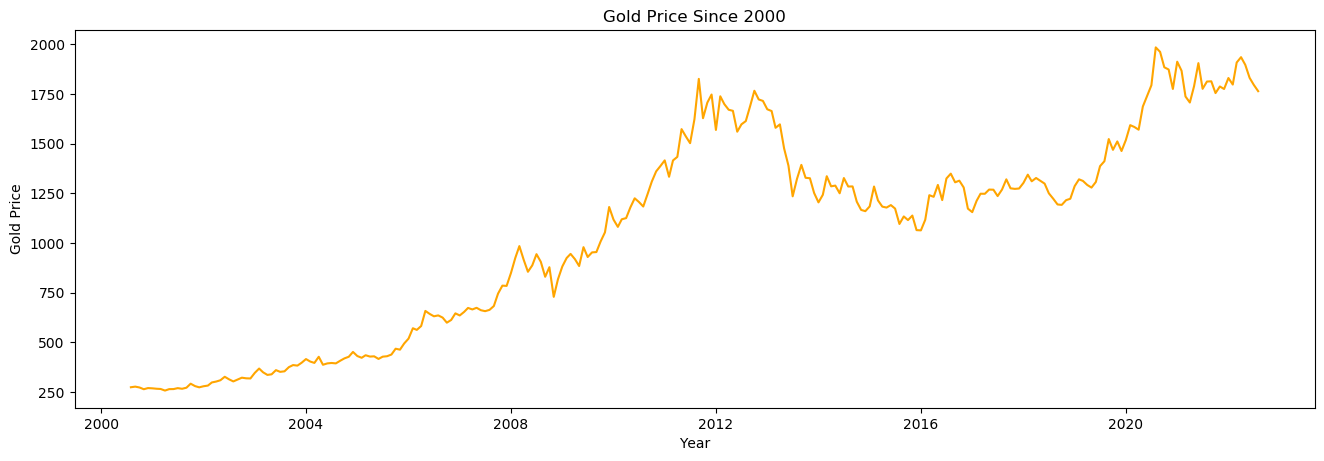

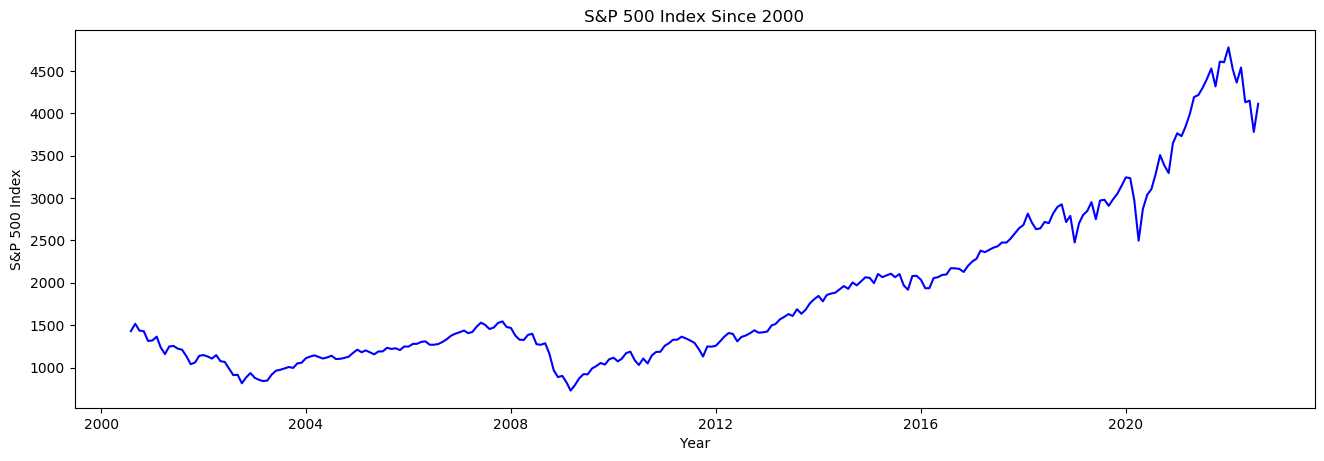

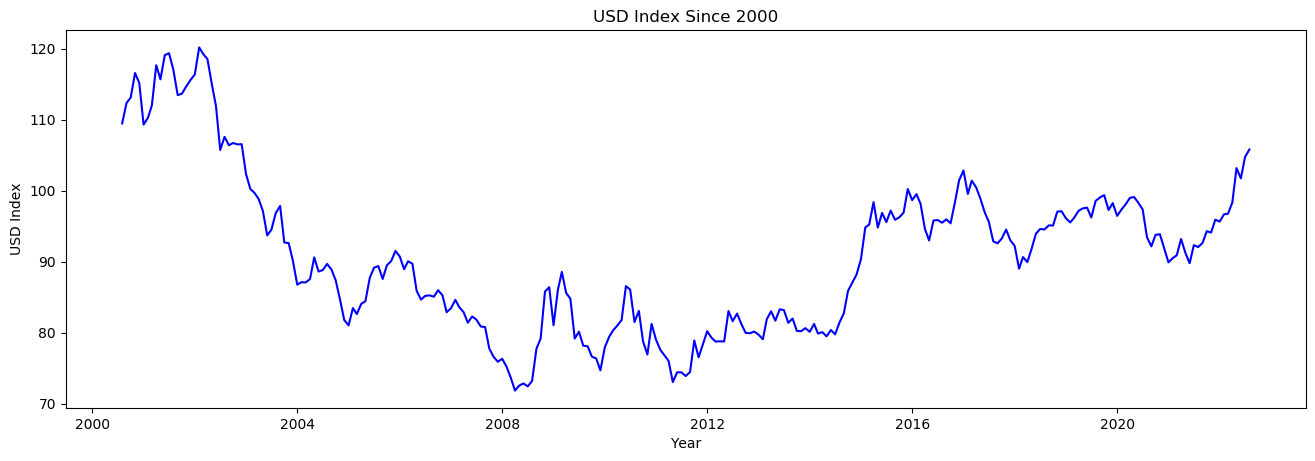

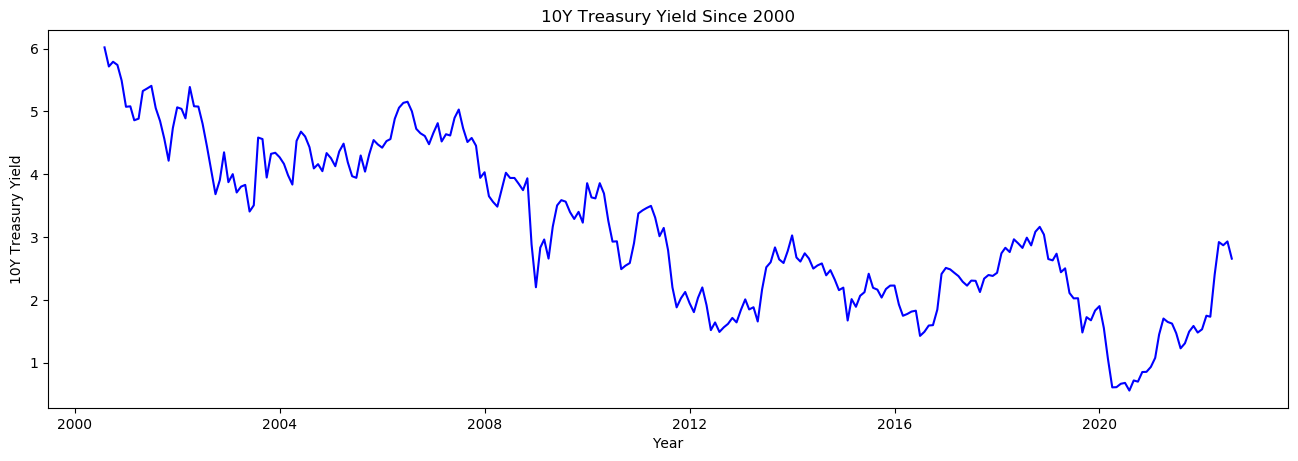

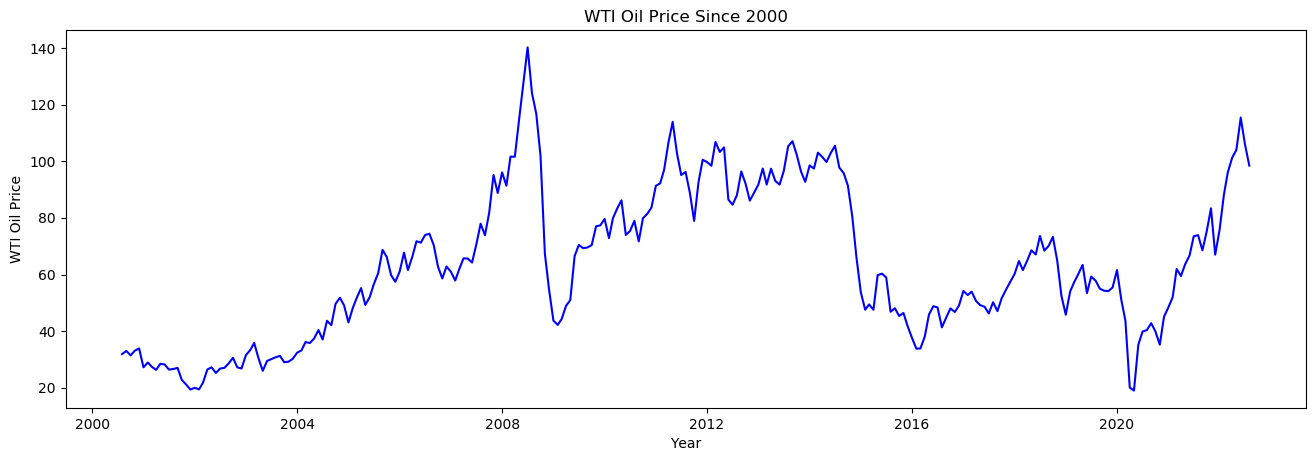

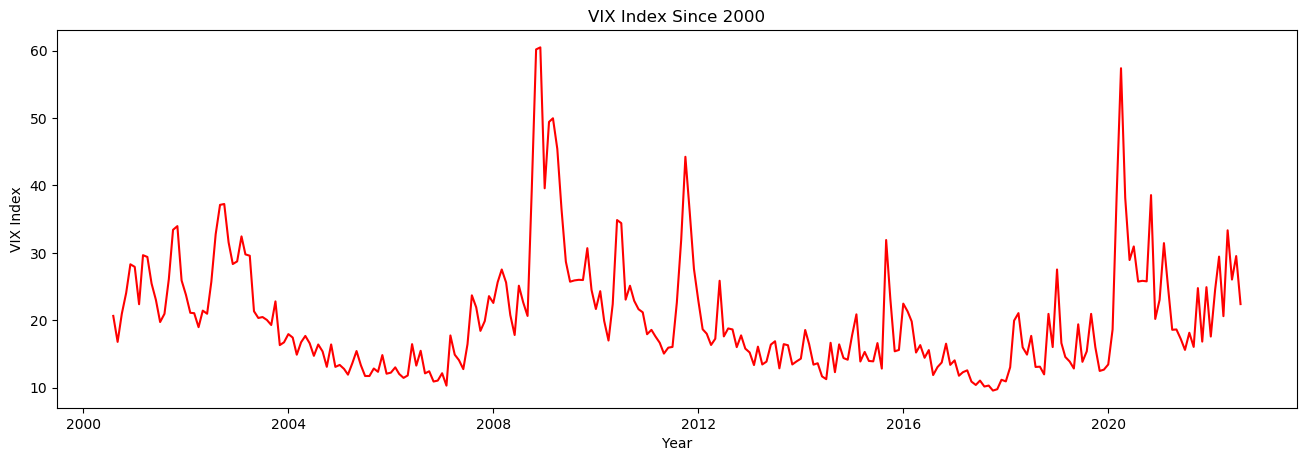

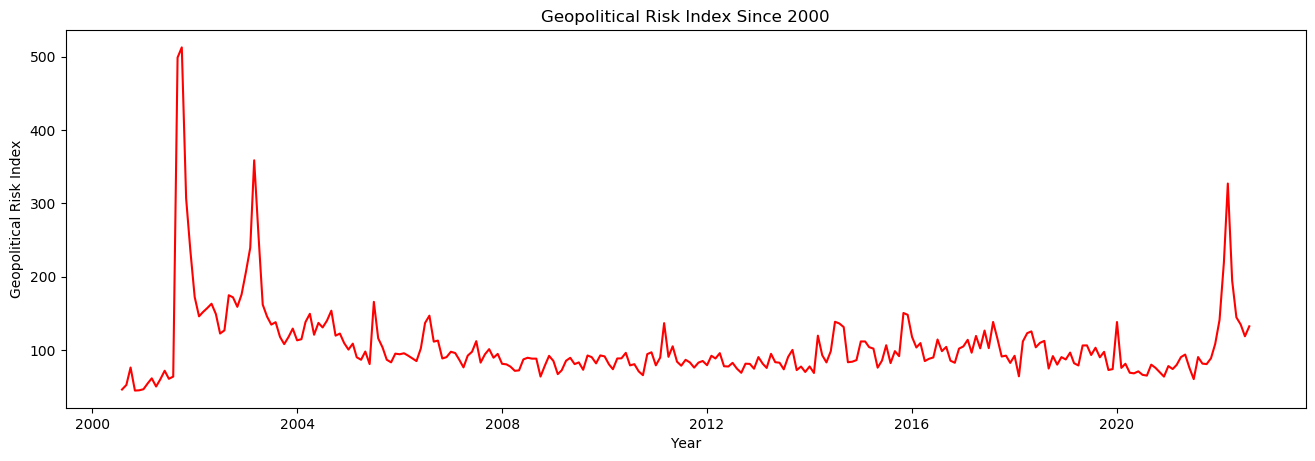

In [15]:
def plot_line(df, series, color, title, ylabel):
    plt.figure(figsize=(16,5), dpi=100)
    plt.plot(df[series], color=color)
    plt.gca().set(title=title, xlabel='Year', ylabel=ylabel)
    plt.show()

plot_line(df, 'gold_price'  , 'orange', 'Gold Price Since 2000'             , 'Gold Price')
plot_line(df, 'sp500'       , 'blue'  , 'S&P 500 Index Since 2000'          , 'S&P 500 Index')
plot_line(df, 'usd'         , 'blue'  , 'USD Index Since 2000'              , 'USD Index')
plot_line(df, 'treasury_10y', 'blue'  , '10Y Treasury Yield Since 2000'     , '10Y Treasury Yield')
plot_line(df, 'oil_price'   , 'blue'  , 'WTI Oil Price Since 2000'          , 'WTI Oil Price')
plot_line(df, 'vix'         , 'red'   , 'VIX Index Since 2000'              , 'VIX Index')
plot_line(df, 'GPR'         , 'red'   , 'Geopolitical Risk Index Since 2000', 'Geopolitical Risk Index')

# 3. ARIMA Model

In [16]:
gold_i0_pvalue         = adfuller(df_train['gold_price'])[1]
sp500_i0_pvalue        = adfuller(df_train['sp500'])[1]
usd_i0_pvalue          = adfuller(df_train['usd'])[1]
treasury_10y_i0_pvalue = adfuller(df_train['treasury_10y'])[1]
oil_i0_pvalue          = adfuller(df_train['oil_price'])[1]
vix_i0_pvalue          = adfuller(df_train['vix'])[1]
grisk_i0_pvalue        = adfuller(df_train['GPR'])[1]

print('--- I(0) p-values ---')
print('Gold             :', gold_i0_pvalue)
print('S&P 500          :', sp500_i0_pvalue)
print('USD              :', usd_i0_pvalue)
print('Treasury 10Y     :', treasury_10y_i0_pvalue)
print('Oil              :', oil_i0_pvalue)
print('VIX              :', vix_i0_pvalue)
print('Geopolitical Risk:', grisk_i0_pvalue)

--- I(0) p-values ---
Gold             : 0.5859904915840377
S&P 500          : 0.9643529645573934
USD              : 0.4820499200254617
Treasury 10Y     : 0.6993232368293943
Oil              : 0.26375834522833586
VIX              : 0.011340712445068768
Geopolitical Risk: 0.13545418399843806


In [17]:
df_train_i1 = df_train.diff().dropna()

gold_i1_pvalue         = adfuller(df_train_i1['gold_price'])[1]
sp500_i1_pvalue        = adfuller(df_train_i1['sp500'])[1]
usd_i1_pvalue          = adfuller(df_train_i1['usd'])[1]
treasury_10y_i1_pvalue = adfuller(df_train_i1['treasury_10y'])[1]
oil_i1_pvalue          = adfuller(df_train_i1['oil_price'])[1]
vix_i1_pvalue          = adfuller(df_train_i1['vix'])[1]
grisk_i1_pvalue        = adfuller(df_train_i1['GPR'])[1]

print('--- I(1) p-values ---')
print('Gold             :', gold_i1_pvalue)
print('S&P 500          :', sp500_i1_pvalue)
print('USD              :', usd_i1_pvalue)
print('Treasury 10Y     :', treasury_10y_i1_pvalue)
print('Oil              :', oil_i1_pvalue)
print('VIX              :', vix_i1_pvalue)
print('Geopolitical Risk:', grisk_i1_pvalue)

--- I(1) p-values ---
Gold             : 0.04125196774324308
S&P 500          : 1.3629590283408107e-23
USD              : 0.0012124504425957826
Treasury 10Y     : 5.87269537457013e-11
Oil              : 4.648934296656443e-09
VIX              : 1.3957140804593767e-11
Geopolitical Risk: 5.7613087416062675e-15


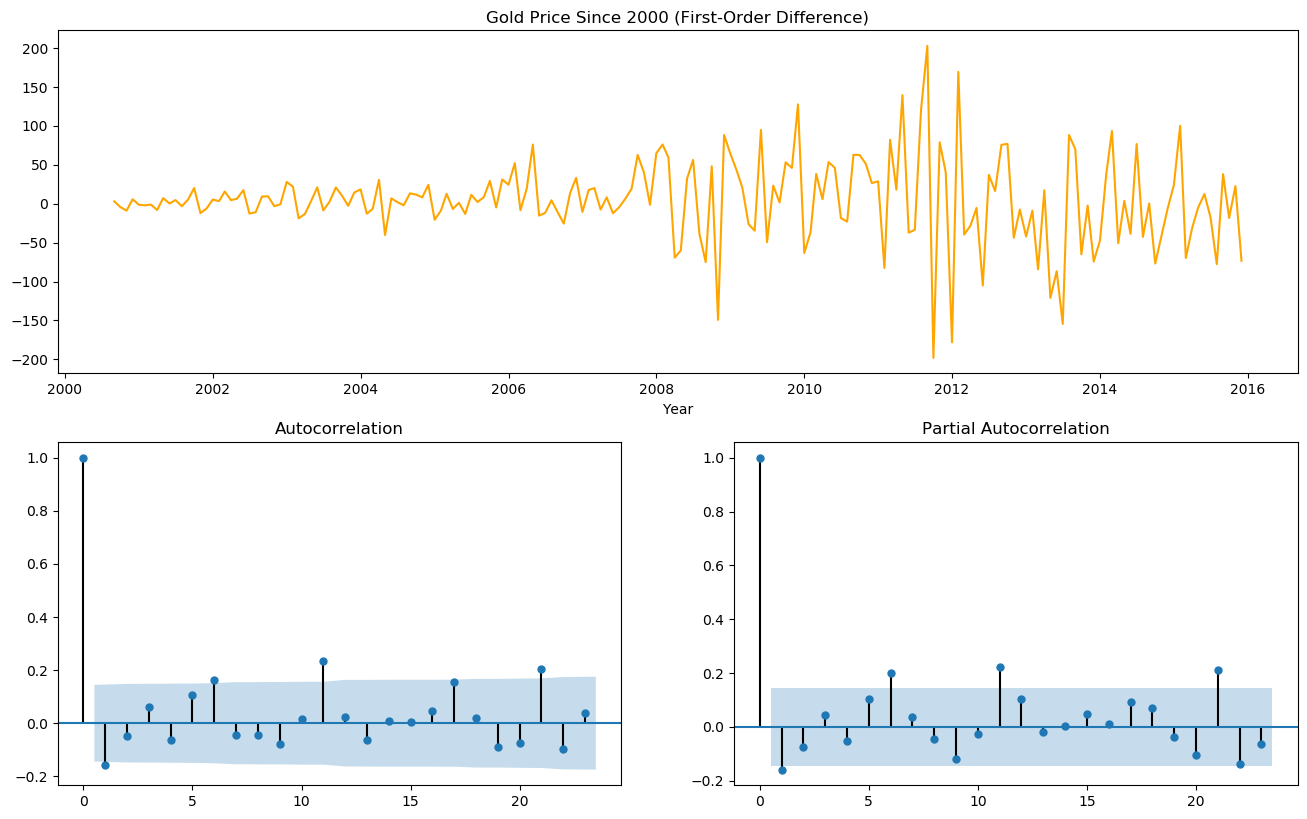

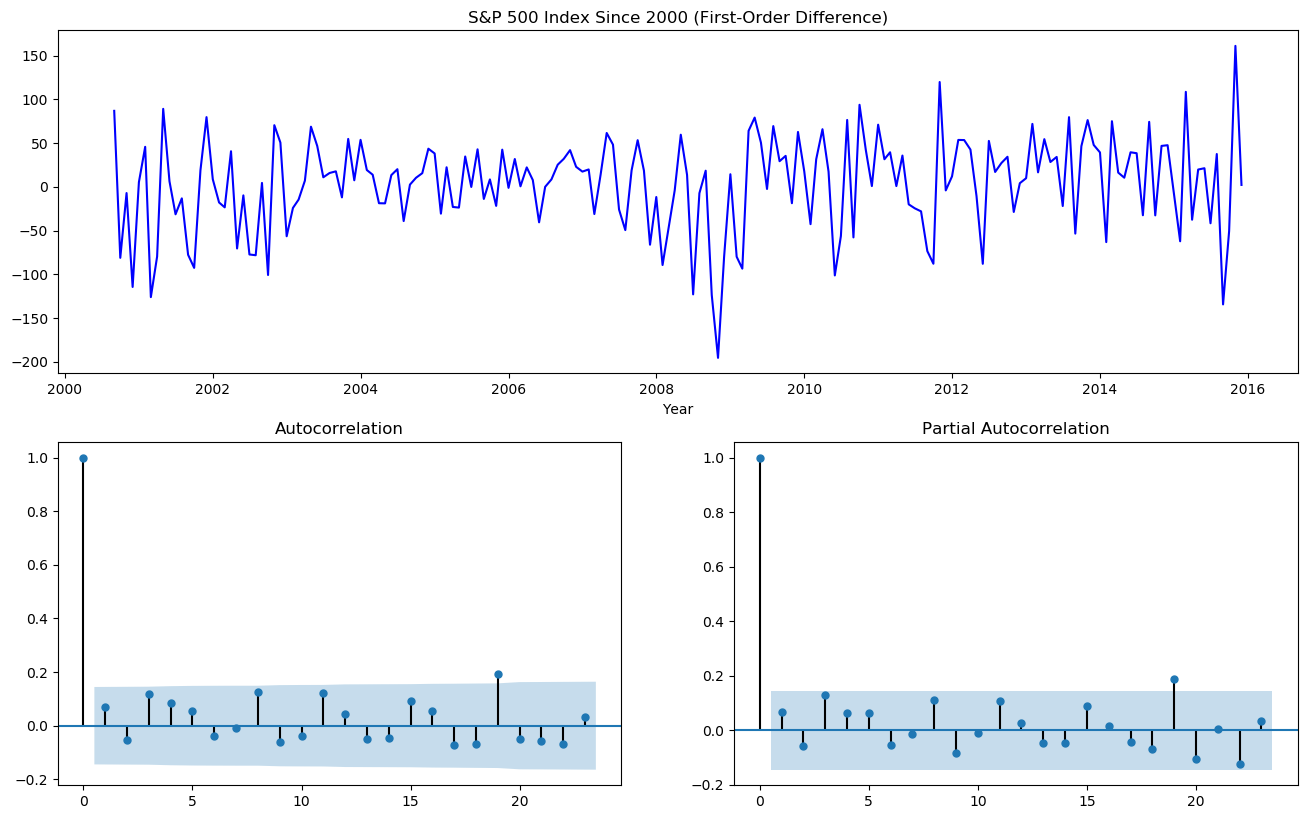

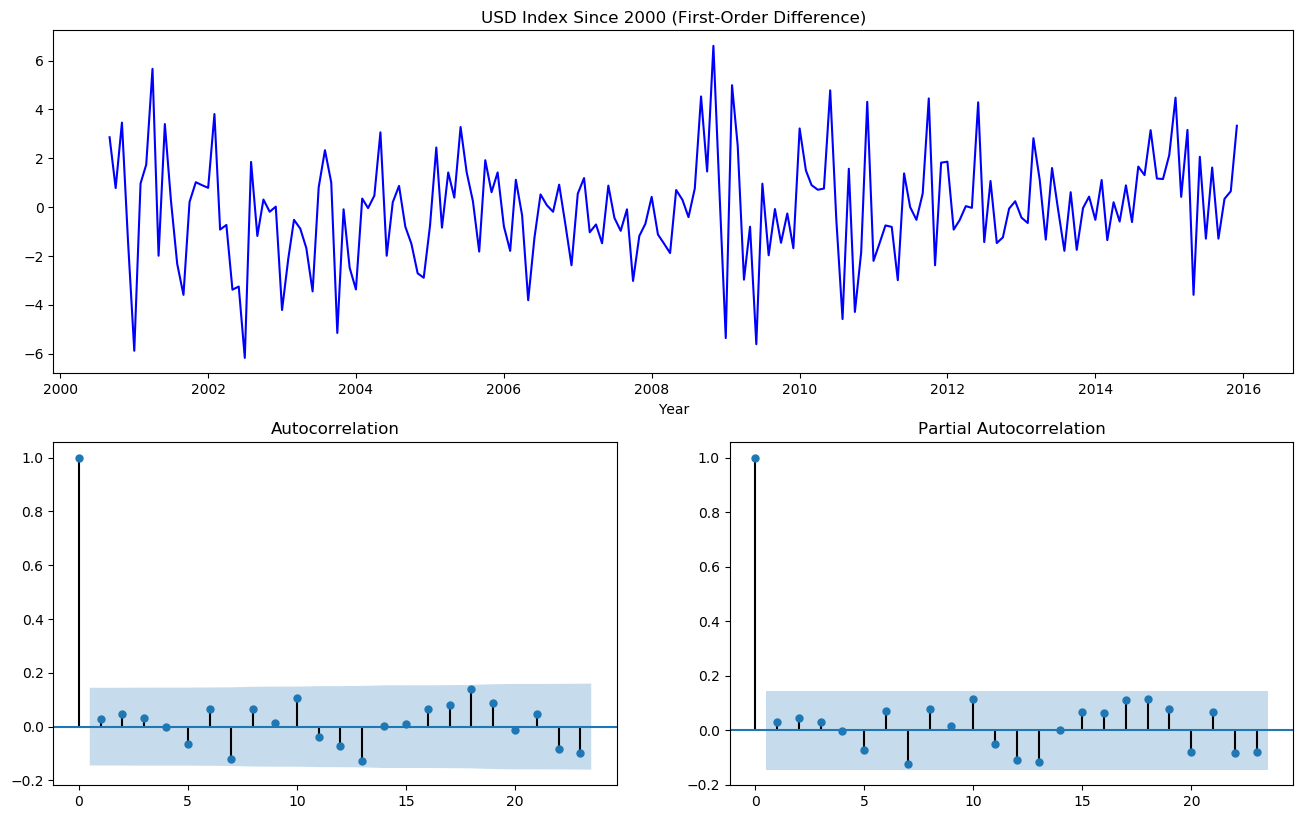

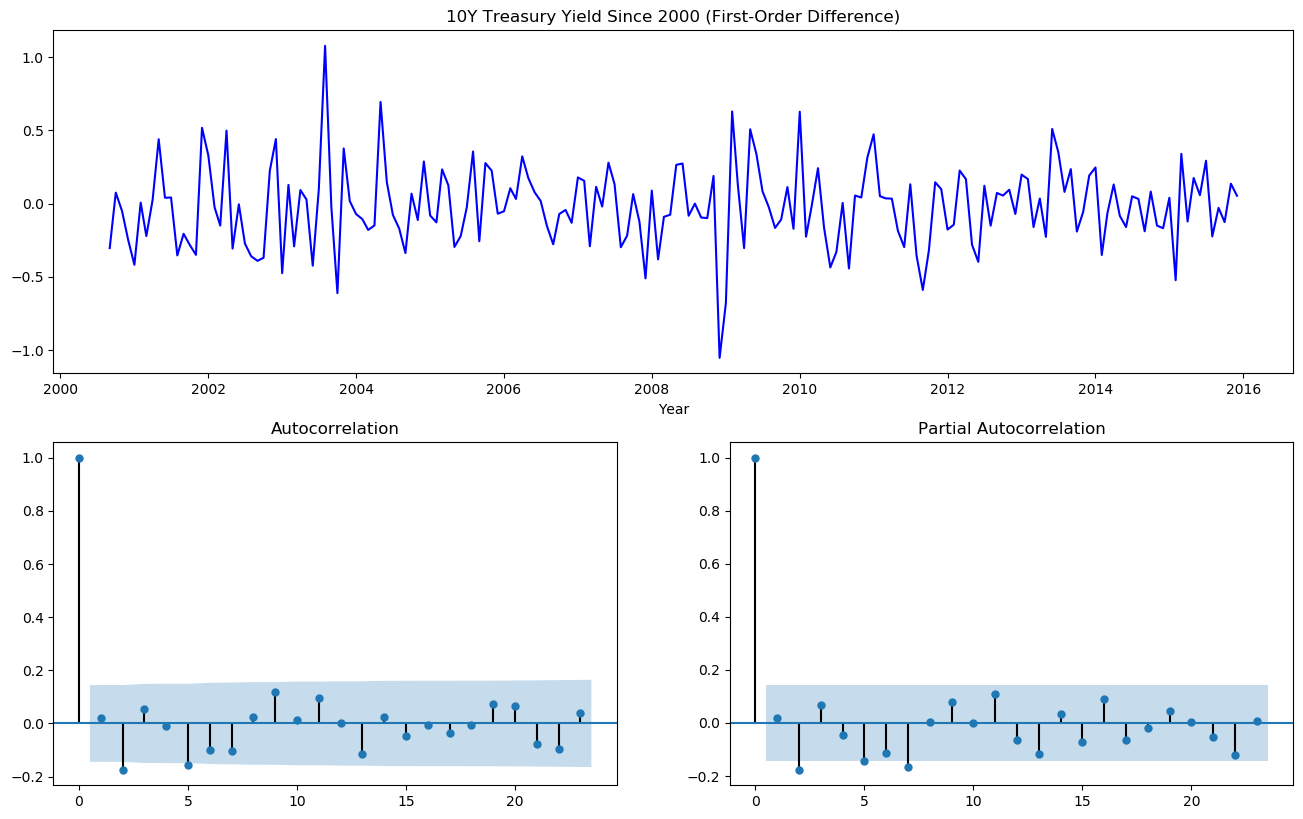

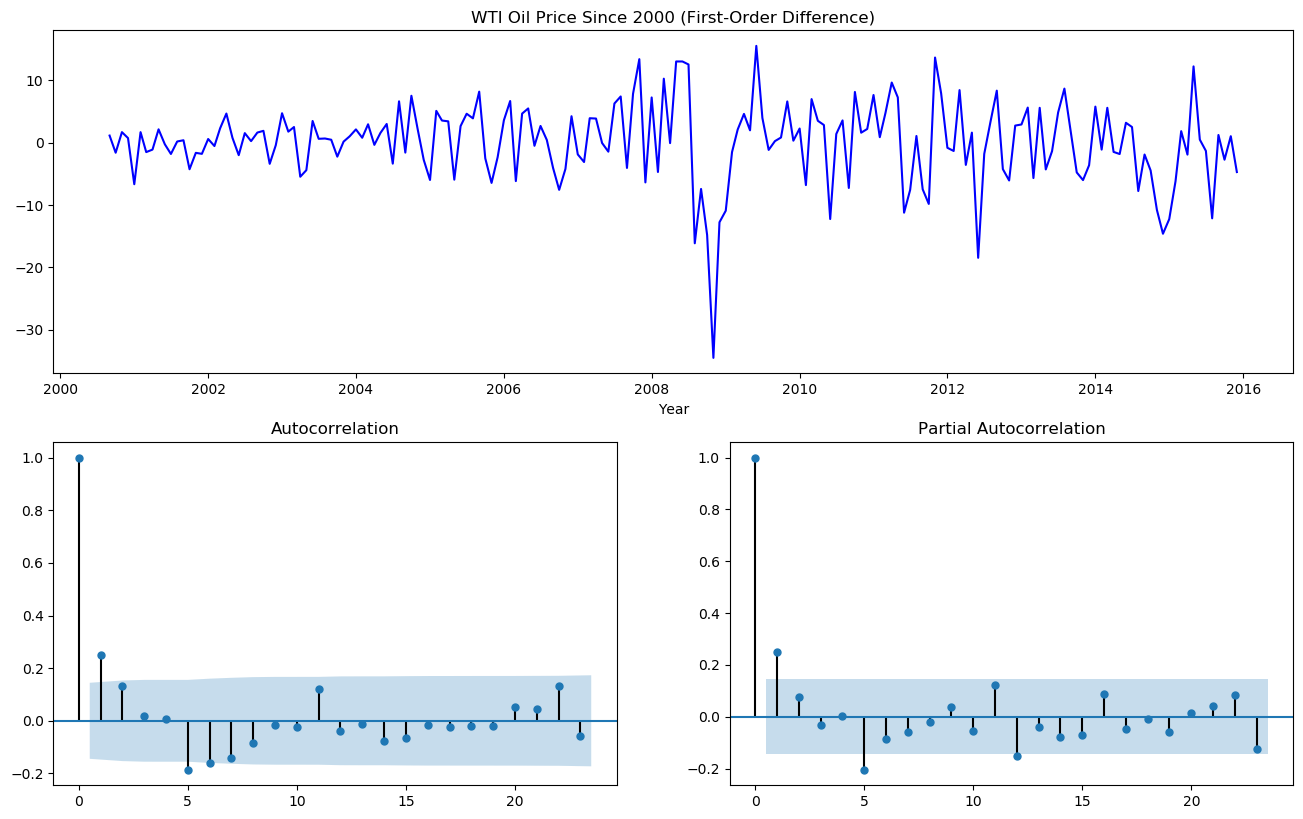

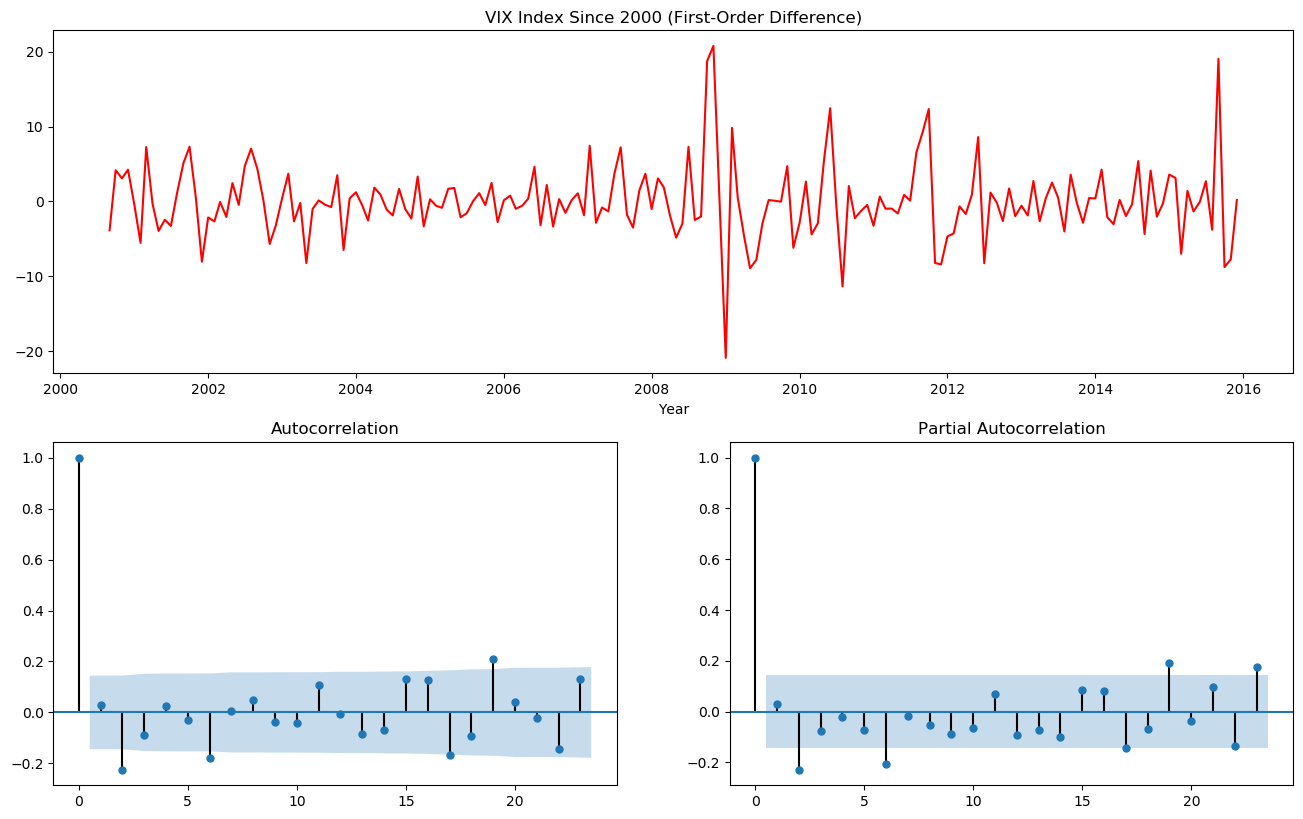

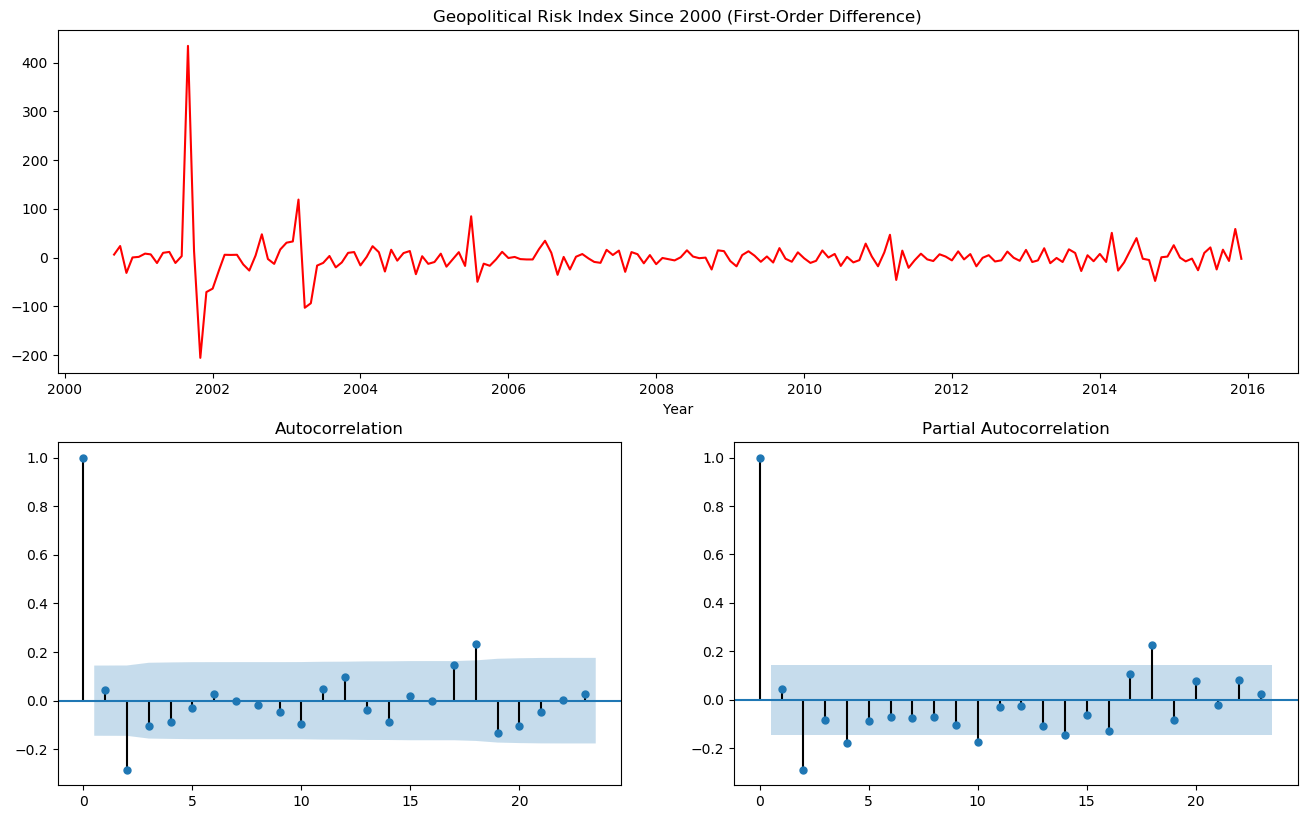

In [18]:
def plot_acf_pacf(df, series, title, color):
    f = plt.figure(figsize=(16,10), dpi=100)
    
    ax1 = f.add_subplot(211)
    plt.plot(df[series], color=color)
    plt.gca().set(title=title, xlabel='Year')
    
    ax2 = f.add_subplot(223)
    plot_acf(df[series], ax=ax2)
    
    ax3 = f.add_subplot(224)
    plot_pacf(df[series], ax=ax3)
    
    plt.show()

plot_acf_pacf(df_train_i1, 'gold_price'  , 'Gold Price Since 2000 (First-Order Difference)'              , 'orange')
plot_acf_pacf(df_train_i1, 'sp500'       , 'S&P 500 Index Since 2000 (First-Order Difference)'           , 'blue')
plot_acf_pacf(df_train_i1, 'usd'         , 'USD Index Since 2000 (First-Order Difference)'               , 'blue')
plot_acf_pacf(df_train_i1, 'treasury_10y', '10Y Treasury Yield Since 2000 (First-Order Difference)'      , 'blue')
plot_acf_pacf(df_train_i1, 'oil_price'   , 'WTI Oil Price Since 2000 (First-Order Difference)'           , 'blue')
plot_acf_pacf(df_train_i1, 'vix'         , 'VIX Index Since 2000 (First-Order Difference)'               , 'red')
plot_acf_pacf(df_train_i1, 'GPR'         , 'Geopolitical Risk Index Since 2000 (First-Order Difference)' , 'red')

In [19]:
model_auto_arima = auto_arima(df_train['gold_price'], seasonal=False, trace=True)
model_auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1991.014, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1991.033, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1988.326, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1987.763, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1990.215, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1989.669, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1989.601, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1989.014, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1987.580, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1989.539, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1989.503, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1987.983, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1988.865, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.358 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  185
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -991.790
Date:                Sat, 10 Sep 2022   AIC                           1987.580
Time:                        14:17:07   BIC                           1994.010
Sample:                    08-01-2000   HQIC                          1990.186
                         - 12-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1635      0.043     -3.801      0.000      -0.248      -0.079
sigma2      2813.7775    193.099     14.572      0.000    2435.311    3192.244
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                59.04
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              34.97   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                             ARIMA Model Results                              
Dep. Variable:           D.gold_price   No. Observations:                  184
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -990.835
Method:                       css-mle   S.D. of innovations             52.770
Date:                Sat, 10 Sep 2022   AIC                           1989.669
Time:                        14:17:13   BIC                           2002.529
Sample:                    09-01-2000   HQIC                          1994.881
                         - 12-01-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.3786      3.156      1.387      0.165      -1.808      10.565
ar.L1.D.gold_price     0.0956      0.303      0.315      0.753      -0.499       0.690
ma.L1.D.gold_price  

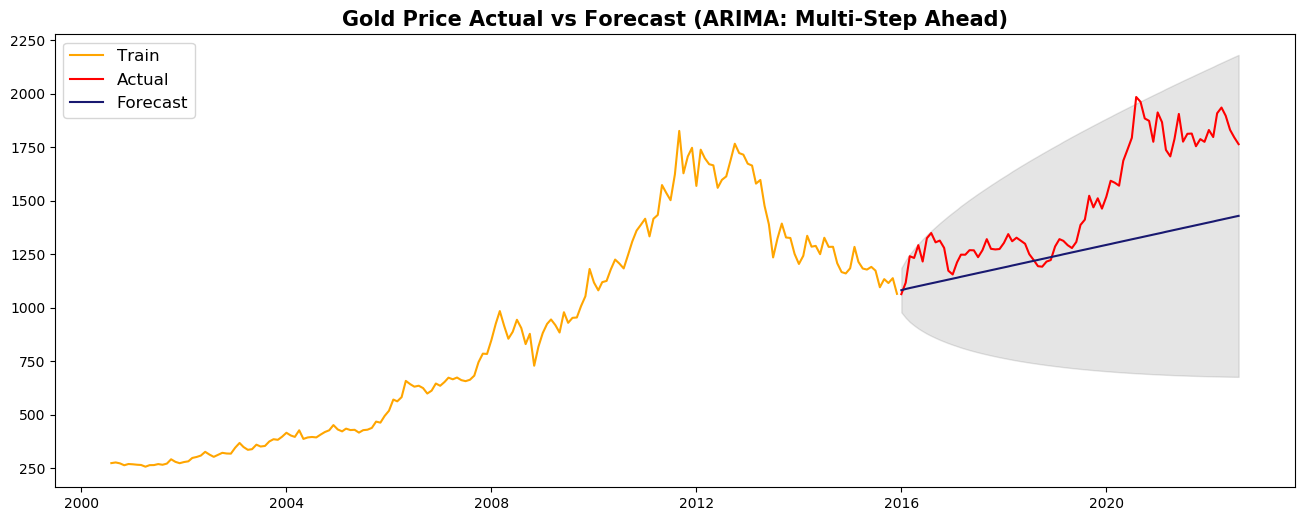

In [20]:
order_pdq = (1,1,1)

# Fit the ARIMA model and print the results.
arima = ARIMA(df_train['gold_price'], order=order_pdq)
model = arima.fit()
print(model.summary())

# Forecast the values during test period (80 months from 2016 to 2022).
fc, se, conf = model.forecast(80, alpha=0.05)

fc_values   = pd.Series(fc        , index=df_test.index)
lower_bound = pd.Series(conf[:, 0], index=df_test.index)
upper_bound = pd.Series(conf[:, 1], index=df_test.index)

# Plot the multi-step ahead forecasted values against the actual values.
plt.figure(figsize=(16,6), dpi=100)
plt.plot(df_train['gold_price'], label='Train'   , color='orange')
plt.plot(df_test['gold_price'] , label='Actual'  , color='red')
plt.plot(fc_values             , label='Forecast', color='midnightblue')
plt.fill_between(df_test.index, lower_bound, upper_bound, color='black', alpha=0.1)
plt.title('Gold Price Actual vs Forecast (ARIMA: Multi-Step Ahead)', fontsize=15, weight='bold')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [21]:
gold_price_2015_12 = df_train.loc['2015-12-01', 'gold_price']
gold_price_2015_11 = df_train.loc['2015-11-01', 'gold_price']
residual_2015_12   = model.resid.loc['2015-12-01']
residual_2016_01   = 0   # Doesn't exist yet
residual_2016_02   = 0   # Doesn't exist yet
residual_2016_03   = 0   # Doesn't exist yet
residual_2016_04   = 0   # Doesn't exist yet

fc_2016_01 = gold_price_2015_12 + model.params[0] + model.params[1] * (gold_price_2015_12 - gold_price_2015_11) \
             + model.params[2] * residual_2015_12
fc_2016_02 = fc_2016_01         + model.params[0] + model.params[1] * (fc_2016_01         - gold_price_2015_12) \
             + model.params[2] * residual_2016_01
fc_2016_03 = fc_2016_02         + model.params[0] + model.params[1] * (fc_2016_02         - fc_2016_01        ) \
             + model.params[2] * residual_2016_02
fc_2016_04 = fc_2016_03         + model.params[0] + model.params[1] * (fc_2016_03         - fc_2016_02        ) \
             + model.params[2] * residual_2016_03
fc_2016_05 = fc_2016_04         + model.params[0] + model.params[1] * (fc_2016_04         - fc_2016_03        ) \
             + model.params[2] * residual_2016_04

print(round(fc_2016_01 / fc[0], 4))
print(round(fc_2016_02 / fc[1], 4))
print(round(fc_2016_03 / fc[2], 4))
print(round(fc_2016_04 / fc[3], 4))
print(round(fc_2016_05 / fc[4], 4))

1.0004
1.0008
1.0012
1.0016
1.0021


In [22]:
arima_predictions = []
test_length = 80

for i in range(len(df)-test_length, len(df)):
    order_pdq = (1,1,1)
    arima = ARIMA(df['gold_price'][:i], order=order_pdq)
    model = arima.fit()
    one_step_forecast = model.forecast()[0][0]
    arima_predictions.append(one_step_forecast)

actual_test = df['gold_price'][-test_length:]
arima_predictions = pd.concat([actual_test, pd.DataFrame(arima_predictions).set_index(actual_test.index)], axis=1)
arima_predictions.columns = ['actual_gold_price', 'forecast_gold_price']

arima_predictions

,actual_gold_price,forecast_gold_price
monthyear,,
2016-01-01,1063.4,1081.720680
2016-02-01,1116.7,1071.990781
2016-03-01,1240.5,1114.148244
2016-04-01,1232.3,1224.503564
2016-05-01,1292.1,1232.885016
...,...,...
2022-04-01,1935.0,1900.901495
2022-05-01,1896.7,1933.924082
2022-06-01,1831.0,1906.372130


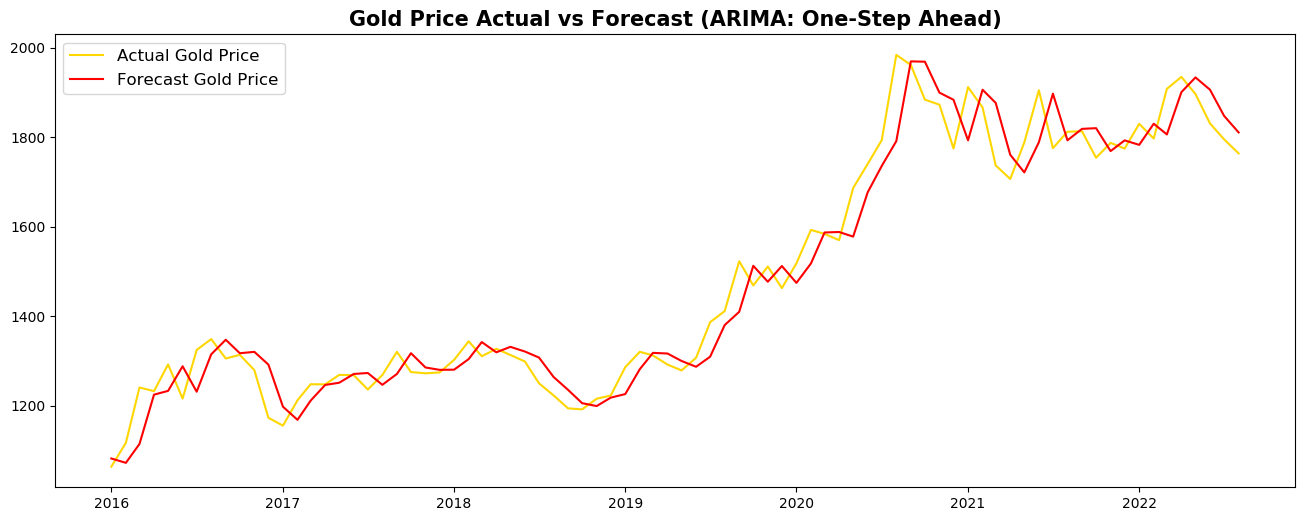

In [23]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(arima_predictions['actual_gold_price']  , label='Actual Gold Price'  , color='gold')
plt.plot(arima_predictions['forecast_gold_price'], label='Forecast Gold Price', color='red')
plt.title('Gold Price Actual vs Forecast (ARIMA: One-Step Ahead)', fontsize=15, weight='bold')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [24]:
arima_predictions['naive_gold_price'] = arima_predictions['actual_gold_price'].shift(1)
arima_predictions.dropna(inplace=True)

arima_predictions

,actual_gold_price,forecast_gold_price,naive_gold_price
monthyear,,,
2016-02-01,1116.7,1071.990781,1063.4
2016-03-01,1240.5,1114.148244,1116.7
2016-04-01,1232.3,1224.503564,1240.5
2016-05-01,1292.1,1232.885016,1232.3
2016-06-01,1215.7,1287.931249,1292.1
...,...,...,...
2022-04-01,1935.0,1900.901495,1908.3
2022-05-01,1896.7,1933.924082,1935.0
2022-06-01,1831.0,1906.372130,1896.7


In [25]:
def rmse(df, actual, forecast):
    df['se'] = (df[actual]-df[forecast])**2
    rmse     = (df.se.mean())**0.5
    return round(rmse, 4)

rmse_arima = rmse(arima_predictions, 'actual_gold_price', 'forecast_gold_price')
rmse_naive = rmse(arima_predictions, 'actual_gold_price', 'naive_gold_price')

print('RMSE (ARIMA):', rmse_arima)
print('RMSE (Naive):', rmse_naive)

RMSE (ARIMA): 61.2565
RMSE (Naive): 61.2582


# 4. VAR Model

In [26]:
def granger_causality_matrix(df, test, maxlag):
    df_gc = pd.DataFrame(np.zeros((len(df.columns), len(df.columns))), columns=df.columns, index=df.columns)
    for c in df_gc.columns:
        for r in df_gc.index:
            gc_results      = grangercausalitytests(df[[r, c]], maxlag=maxlag, verbose=False)
            p_values        = [round(gc_results[i+1][0][test][1], 4) for i in range(maxlag)]
            min_p_value     = np.min(p_values)
            df_gc.loc[r, c] = min_p_value
    df_gc.columns = [i + '_x' for i in df_gc.columns]
    df_gc.index   = [i + '_y' for i in df_gc.index]
    
    return df_gc

granger_causality_matrix(df_train_i1, 'ssr_chi2test', 12)

,gold_price_x,sp500_x,usd_x,treasury_10y_x,oil_price_x,vix_x,GPR_x
gold_price_y,1.0000,0.5308,0.6430,0.3565,0.0374,0.1284,0.7725
sp500_y,0.0012,1.0000,0.0974,0.2142,0.0308,0.0069,0.0218
usd_y,0.1569,0.1924,1.0000,0.0891,0.0159,0.1083,0.0268
treasury_10y_y,0.3341,0.0006,0.1241,1.0000,0.0004,0.0000,0.1759
oil_price_y,0.0003,0.2308,0.0483,0.0071,1.0000,0.0150,0.6621
vix_y,0.1315,0.0554,0.0592,0.0458,0.0004,1.0000,0.0796
GPR_y,0.3462,0.0051,0.0000,0.2294,0.6088,0.1896,1.0000


In [27]:
var = VAR(df_train_i1)
var_select_order = var.select_order(maxlags=12)
var_select_order.summary()

,AIC,BIC,FPE,HQIC
0,27.79*,27.92*,1.175e+12*,27.84*
1,27.93,28.95,1.343e+12,28.34
2,27.95,29.87,1.380e+12,28.73
3,28.09,30.90,1.592e+12,29.23
4,28.33,32.05,2.065e+12,29.84
5,28.38,32.99,2.206e+12,30.25
6,28.39,33.90,2.314e+12,30.63
7,28.56,34.97,2.864e+12,31.16
8,28.72,36.02,3.576e+12,31.69
9,28.71,36.91,3.832e+12,32.04


In [30]:
for i in range(0,13):
    var = VAR(df_train_i1)
    model = var.fit(i)
    print('Lag Order:', i)
    print('AIC      :', round(model.aic, 3))

Lag Order: 0
AIC      : 27.779
Lag Order: 1
AIC      : 27.89
Lag Order: 2
AIC      : 27.919
Lag Order: 3
AIC      : 28.076
Lag Order: 4
AIC      : 28.255
Lag Order: 5
AIC      : 28.304
Lag Order: 6
AIC      : 28.335
Lag Order: 7
AIC      : 28.527
Lag Order: 8
AIC      : 28.648
Lag Order: 9
AIC      : 28.683
Lag Order: 10
AIC      : 28.489
Lag Order: 11
AIC      : 28.563
Lag Order: 12
AIC      : 28.414


In [31]:
var = VAR(df_train_i1)
model = var.fit(1)
print(model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 10, Sep, 2022
Time:                     14:20:27
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    28.8724
Nobs:                     183.000    HQIC:                   28.2884
Log likelihood:          -4313.62    FPE:                1.29645e+12
AIC:                      27.8903    Det(Omega_mle):     9.60906e+11
--------------------------------------------------------------------
Results for equation gold_price
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   5.172762         4.032617            1.283           0.200
L1.gold_price          -0.195769         0.082287           -2.379           0.017
L1.sp500               -0.087393         0.1149

In [32]:
out = durbin_watson(model.resid)

for col, val in zip(df_train_i1.columns, out):
    print(col, ':', round(val, 2))

gold_price : 2.0
sp500 : 1.86
usd : 1.99
treasury_10y : 2.14
oil_price : 2.04
vix : 2.0
GPR : 1.96


In [33]:
var_forecast = model.forecast(df_train_i1.values[-2:], 80)
var_forecast = pd.DataFrame(var_forecast,
                            index=df_test.index,
                            columns=df_test.columns + '_1d')
var_forecast

,gold_price_1d,sp500_1d,usd_1d,treasury_10y_1d,oil_price_1d,vix_1d,GPR_1d
monthyear,,,,,,,
2016-01-01,15.627095,14.837610,-0.072567,-0.008549,0.702865,-0.421933,0.432614
2016-02-01,1.772212,0.726125,0.045109,-0.010284,0.028564,0.251159,-0.110693
2016-03-01,4.691413,3.184325,-0.086126,-0.023016,0.044491,-0.042994,0.528923
2016-04-01,4.357420,3.191389,-0.069828,-0.019113,0.043758,-0.016791,0.527258
2016-05-01,4.346246,3.113544,-0.068606,-0.019577,0.043888,-0.010529,0.510037
...,...,...,...,...,...,...,...
2022-04-01,4.354601,3.121979,-0.069057,-0.019609,0.043052,-0.012057,0.513761
2022-05-01,4.354601,3.121979,-0.069057,-0.019609,0.043052,-0.012057,0.513761
2022-06-01,4.354601,3.121979,-0.069057,-0.019609,0.043052,-0.012057,0.513761


In [34]:
for i in df.columns:
    var_forecast[str(i) + '_forecast'] = df_train[i].iloc[-1] + var_forecast[str(i) + '_1d'].cumsum()

var_forecast

,gold_price_1d,sp500_1d,usd_1d,treasury_10y_1d,oil_price_1d,vix_1d,GPR_1d,gold_price_forecast,sp500_forecast,usd_forecast,treasury_10y_forecast,oil_price_forecast,vix_forecast,GPR_forecast
monthyear,,,,,,,,,,,,,,
2016-01-01,15.627095,14.837610,-0.072567,-0.008549,0.702865,-0.421933,0.432614,1080.227095,2097.767610,100.177433,2.220451,42.432865,15.188067,148.669491
2016-02-01,1.772212,0.726125,0.045109,-0.010284,0.028564,0.251159,-0.110693,1081.999306,2098.493735,100.222543,2.210167,42.461428,15.439227,148.558798
2016-03-01,4.691413,3.184325,-0.086126,-0.023016,0.044491,-0.042994,0.528923,1086.690720,2101.678060,100.136416,2.187151,42.505919,15.396233,149.087720
2016-04-01,4.357420,3.191389,-0.069828,-0.019113,0.043758,-0.016791,0.527258,1091.048140,2104.869449,100.066589,2.168038,42.549677,15.379442,149.614979
2016-05-01,4.346246,3.113544,-0.068606,-0.019577,0.043888,-0.010529,0.510037,1095.394386,2107.982993,99.997983,2.148461,42.593565,15.368913,150.125015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,4.354601,3.121979,-0.069057,-0.019609,0.043052,-0.012057,0.513761,1404.572274,2329.643479,95.094844,0.756226,45.650321,14.512751,186.602797
2022-05-01,4.354601,3.121979,-0.069057,-0.019609,0.043052,-0.012057,0.513761,1408.926875,2332.765458,95.025787,0.736617,45.693373,14.500695,187.116558
2022-06-01,4.354601,3.121979,-0.069057,-0.019609,0.043052,-0.012057,0.513761,1413.281477,2335.887437,94.956730,0.717008,45.736424,14.488638,187.630319


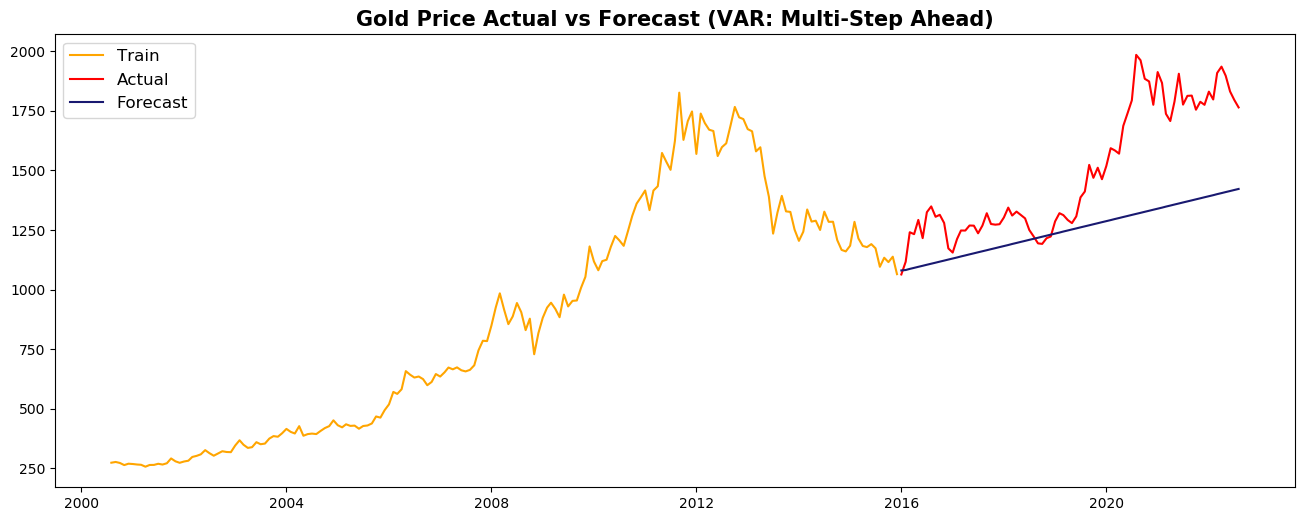

In [35]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(df_train['gold_price']             , label='Train'   , color='orange')
plt.plot(df_test['gold_price']              , label='Actual'  , color='red')
plt.plot(var_forecast['gold_price_forecast'], label='Forecast', color='midnightblue')
plt.title('Gold Price Actual vs Forecast (VAR: Multi-Step Ahead)', fontsize=15, weight='bold')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [38]:
test_length = 80
var_order   = 2
var_predictions = []

df_i1 = df.diff().dropna()

for i in range(len(df_i1)-test_length, len(df_i1)):
    var = VAR(df_i1[:i])
    model = var.fit(var_order)
    var_forecast = model.forecast(df_i1[:i].values[-var_order:], 1)[0][0]
    var_predictions.append(var_forecast)

actual_test = df['gold_price'][-(test_length+1):].shift(1).dropna()
var_predictions = pd.concat([actual_test, pd.DataFrame(var_predictions).set_index(actual_test.index)], axis=1)
var_predictions.columns = ['actual_gold_price_shift', 'forecast_1d']
var_predictions['forecast_gold_price'] = var_predictions['actual_gold_price_shift'] + var_predictions['forecast_1d']
var_predictions = pd.concat([var_predictions, df[['gold_price']]], axis=1, join='inner')
var_predictions.rename(columns={'gold_price': 'actual_gold_price'}, inplace=True)

var_predictions

,actual_gold_price_shift,forecast_1d,forecast_gold_price,actual_gold_price
monthyear,,,,
2016-01-01,1064.6,0.152535,1064.752535,1063.4
2016-02-01,1063.4,1.879385,1065.279385,1116.7
2016-03-01,1116.7,20.637118,1137.337118,1240.5
2016-04-01,1240.5,-10.222622,1230.277378,1232.3
2016-05-01,1232.3,-7.619052,1224.680948,1292.1
...,...,...,...,...
2022-04-01,1908.3,-9.188926,1899.111074,1935.0
2022-05-01,1935.0,-37.188630,1897.811370,1896.7
2022-06-01,1896.7,18.897424,1915.597424,1831.0


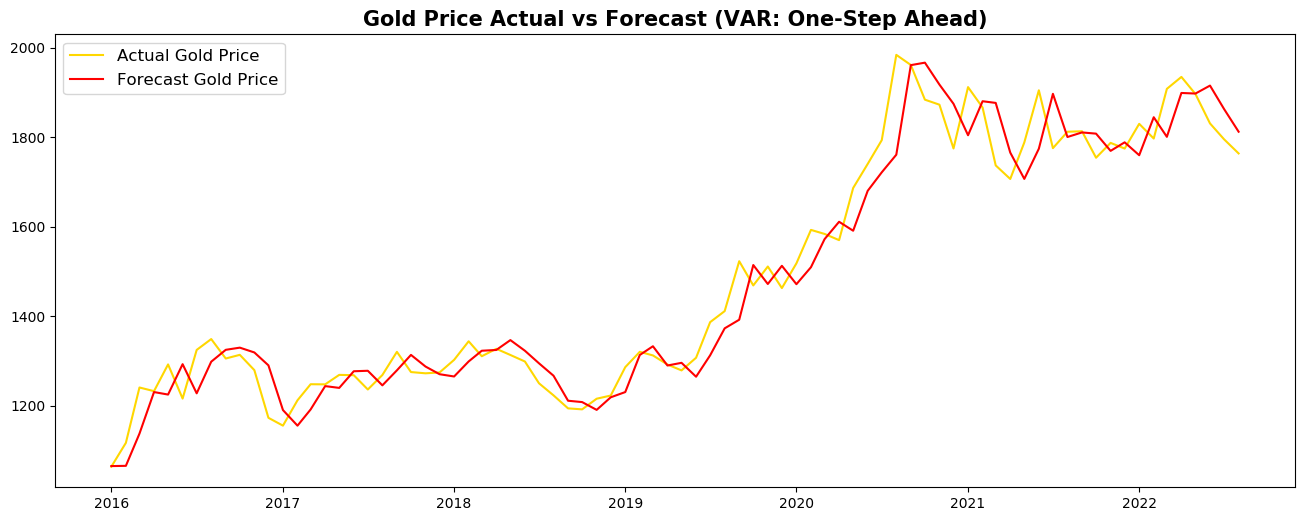

In [39]:
plt.figure(figsize=(16,6), dpi=100)
plt.plot(var_predictions['actual_gold_price']  , label='Actual Gold Price'  , color='gold')
plt.plot(var_predictions['forecast_gold_price'], label='Forecast Gold Price', color='red')
plt.title('Gold Price Actual vs Forecast (VAR: One-Step Ahead)', fontsize=15, weight='bold')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [40]:
rmse_var = rmse(var_predictions, 'actual_gold_price', 'forecast_gold_price')

print('RMSE (ARIMA):', rmse_arima)
print('RMSE (Naive):', rmse_naive)
print('RMSE (VAR)  :', rmse_var  )

RMSE (ARIMA): 61.2565
RMSE (Naive): 61.2582
RMSE (VAR)  : 63.3184


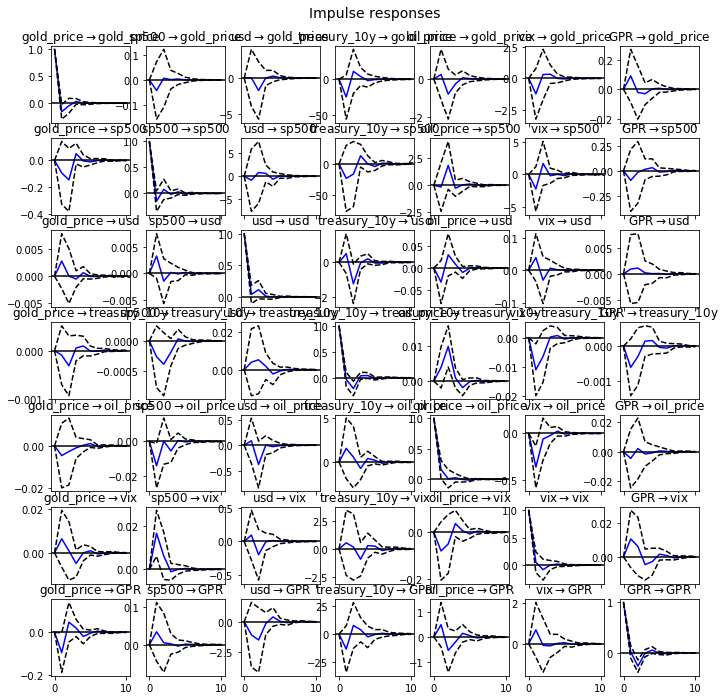

In [41]:
irf = model.irf(10)
irf.plot(orth=False)
plt.show()

In [96]:
fevd = model.fevd(10)
fevd.summary()

FEVD for gold_price
     gold_price     sp500       GPR
0      1.000000  0.000000  0.000000
1      0.997686  0.002101  0.000213
2      0.995267  0.003093  0.001640
3      0.995218  0.003134  0.001648
4      0.995046  0.003166  0.001788
5      0.995041  0.003166  0.001793
6      0.995031  0.003167  0.001802
7      0.995030  0.003167  0.001803
8      0.995029  0.003167  0.001804
9      0.995029  0.003167  0.001804

FEVD for sp500
     gold_price     sp500       GPR
0      0.001513  0.998487  0.000000
1      0.031312  0.950562  0.018126
2      0.042997  0.939096  0.017906
3      0.042906  0.935743  0.021351
4      0.043194  0.935443  0.021362
5      0.043206  0.935103  0.021691
6      0.043209  0.935098  0.021693
7      0.043211  0.935069  0.021720
8      0.043211  0.935069  0.021720
9      0.043212  0.935066  0.021722

FEVD for GPR
     gold_price     sp500       GPR
0      0.005297  0.010170  0.984533
1      0.008426  0.010798  0.980776
2      0.008862  0.013468  0.977670
3      0.00955